In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import cv2

In [3]:
!ls

'My Drive'


In [0]:
def abrir_imagem(img_caminho):
    """
        img_caminho: caminho completo para a imagem
    """
    imagem = cv2.imread(img_caminho, cv2.IMREAD_GRAYSCALE)

    if imagem is None:
        raise NameError("O OpenCV não conseguiu abrir sua imagem. Verique o caminho.")

    return imagem

In [0]:
caminho_absoluto = lambda img_nome:"My Drive/Curso-OMR/images-test/"+img_nome
nome_imagem = "teste1.png"
imagem = abrir_imagem(caminho_absoluto(nome_imagem))

In [0]:
_, imagem_binaria = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

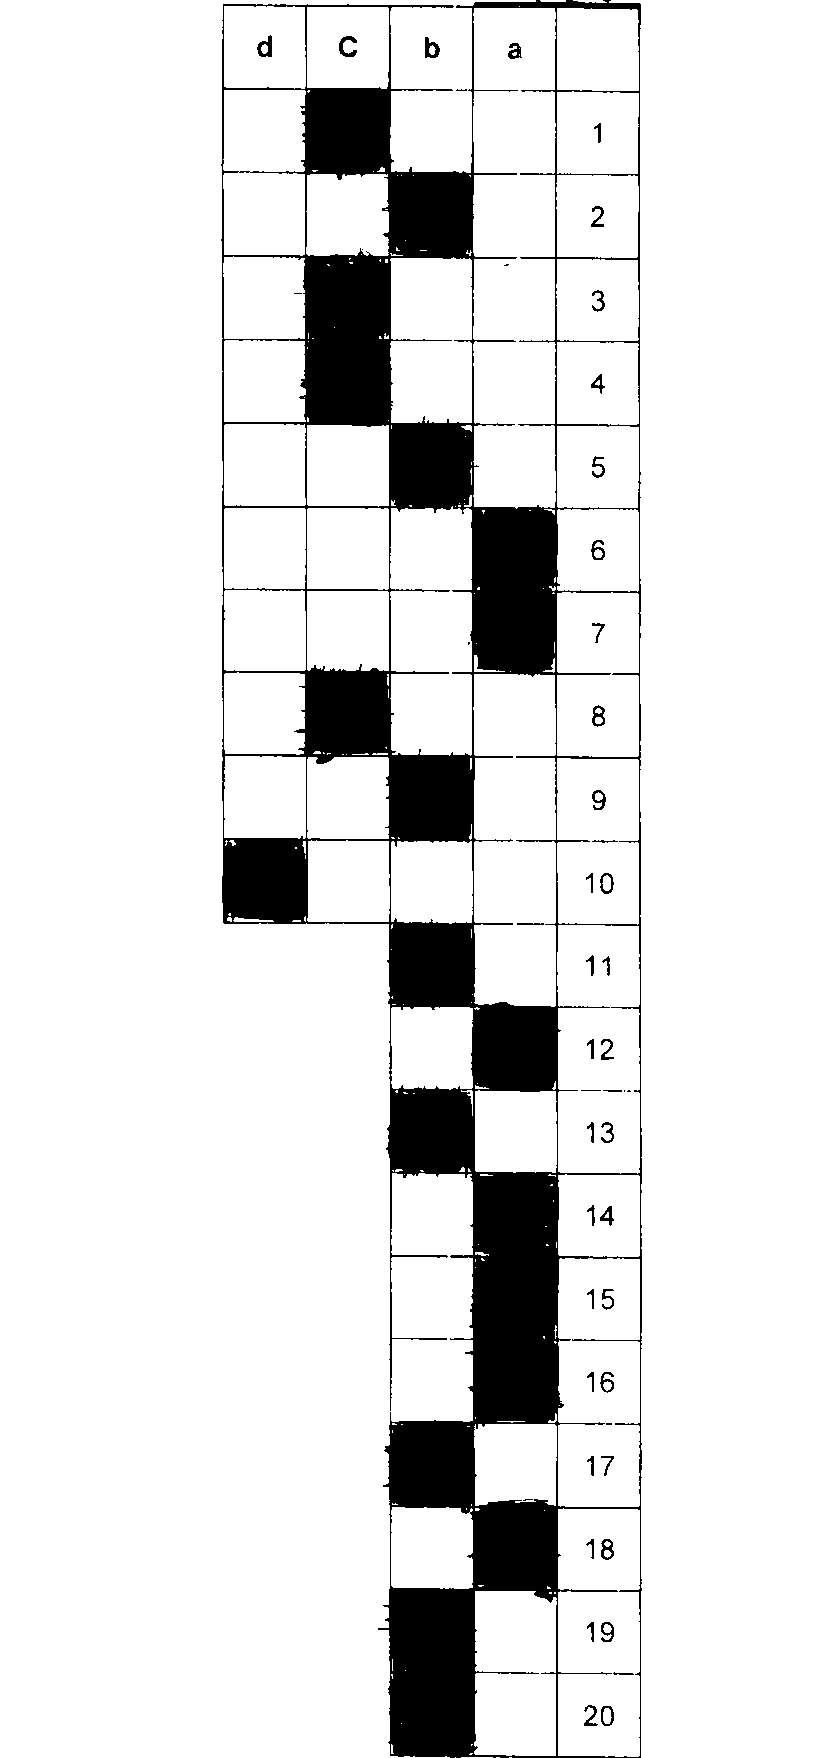

In [7]:
from google.colab.patches import cv2_imshow

cv2_imshow(imagem_binaria)

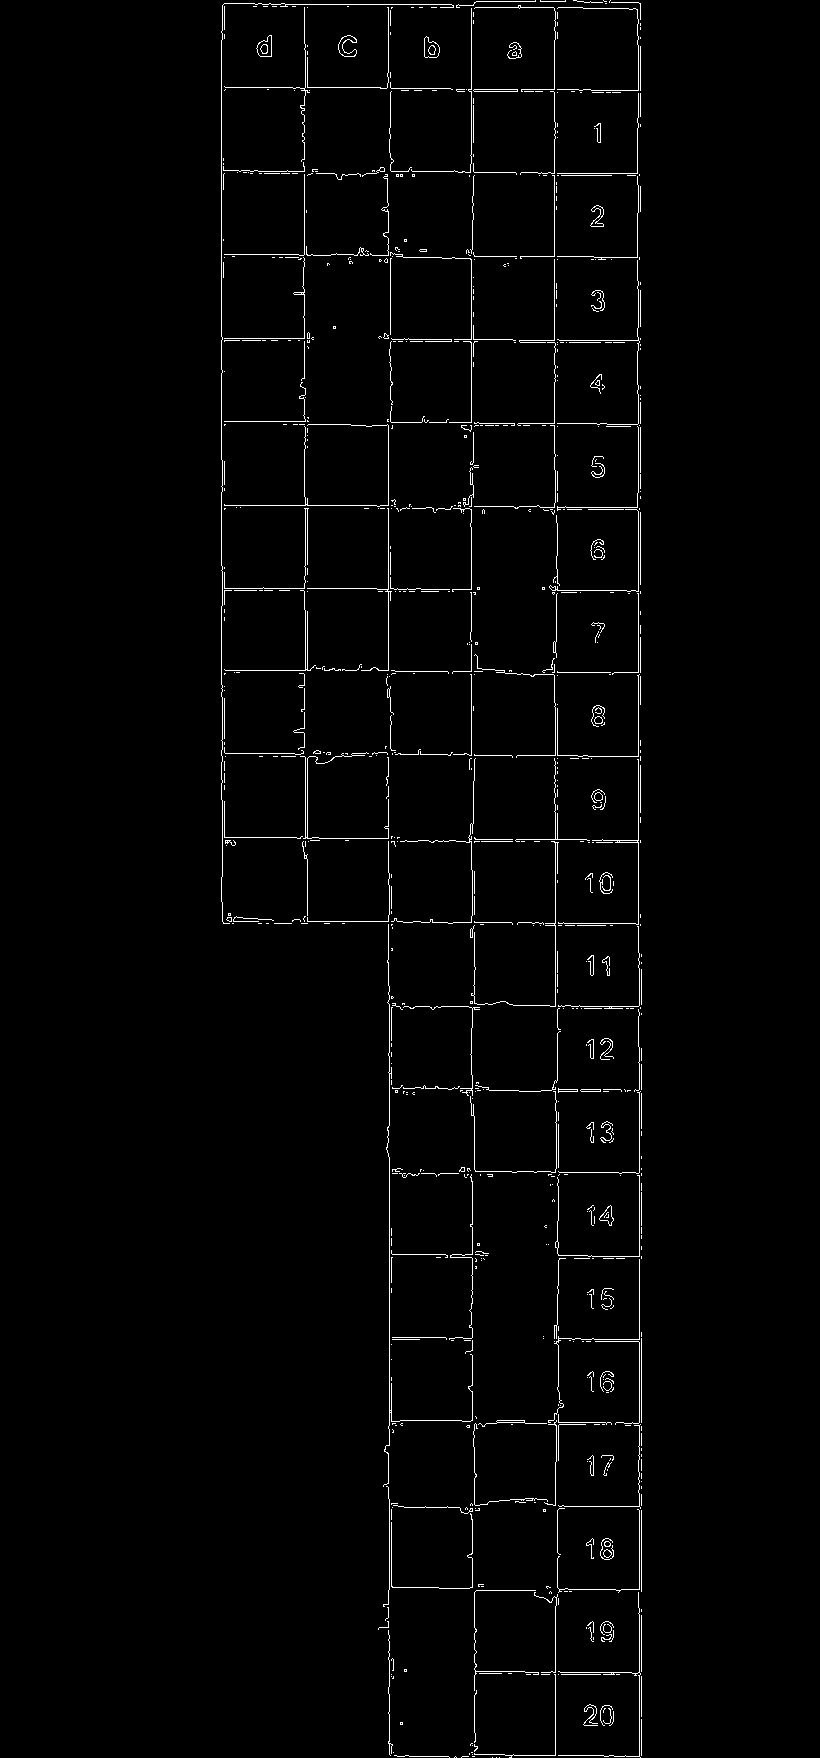

In [8]:
img_canny = cv2.Canny(imagem_binaria, 100, 200)
cv2_imshow(img_canny)

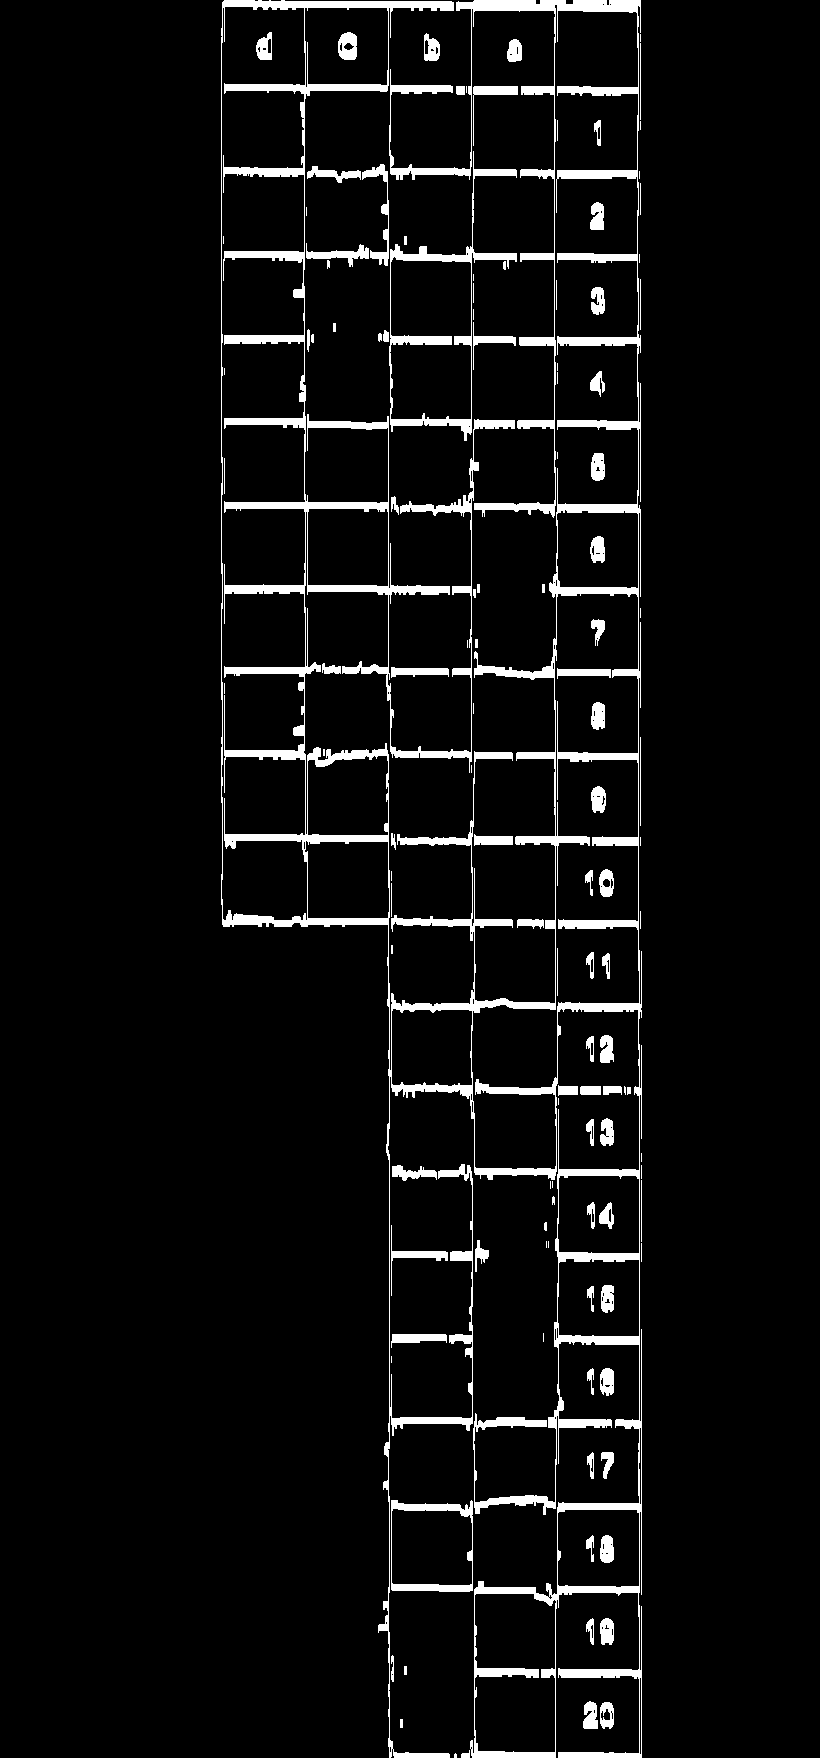

In [9]:
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (1,3))
operacao_dilatar = cv2.morphologyEx(img_canny, cv2.MORPH_DILATE, kernel_rect, iterations=3)

cv2_imshow(operacao_dilatar)

#print(kernel_rect)

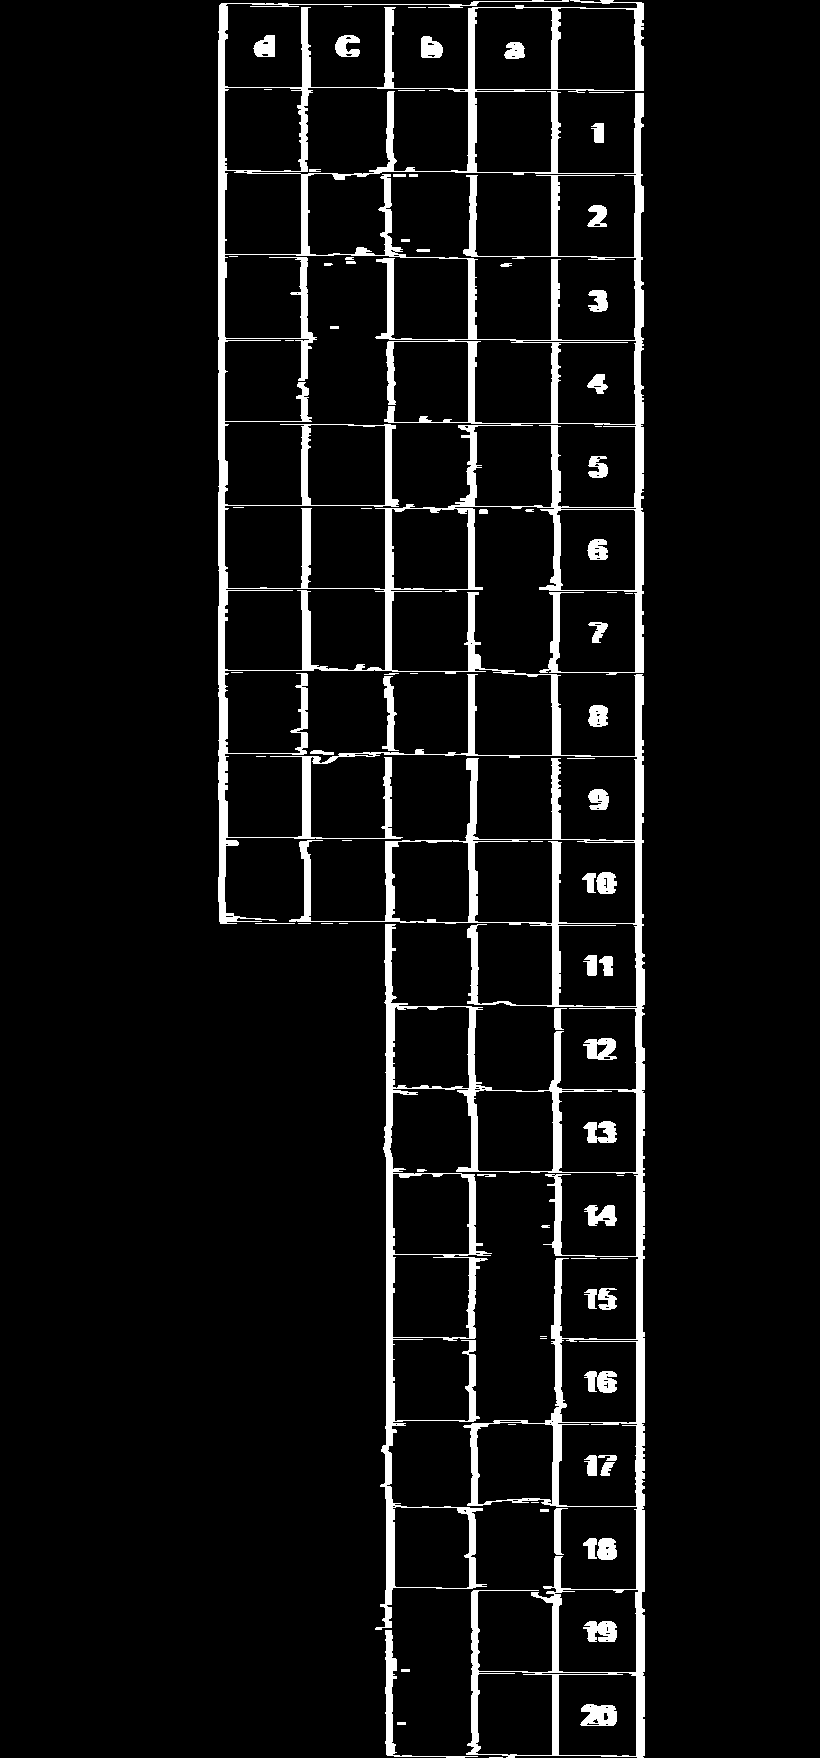

In [10]:
kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
operacao_vertical = cv2.morphologyEx(img_canny, cv2.MORPH_DILATE, kernel_vertical, iterations=3)
cv2_imshow(operacao_vertical)

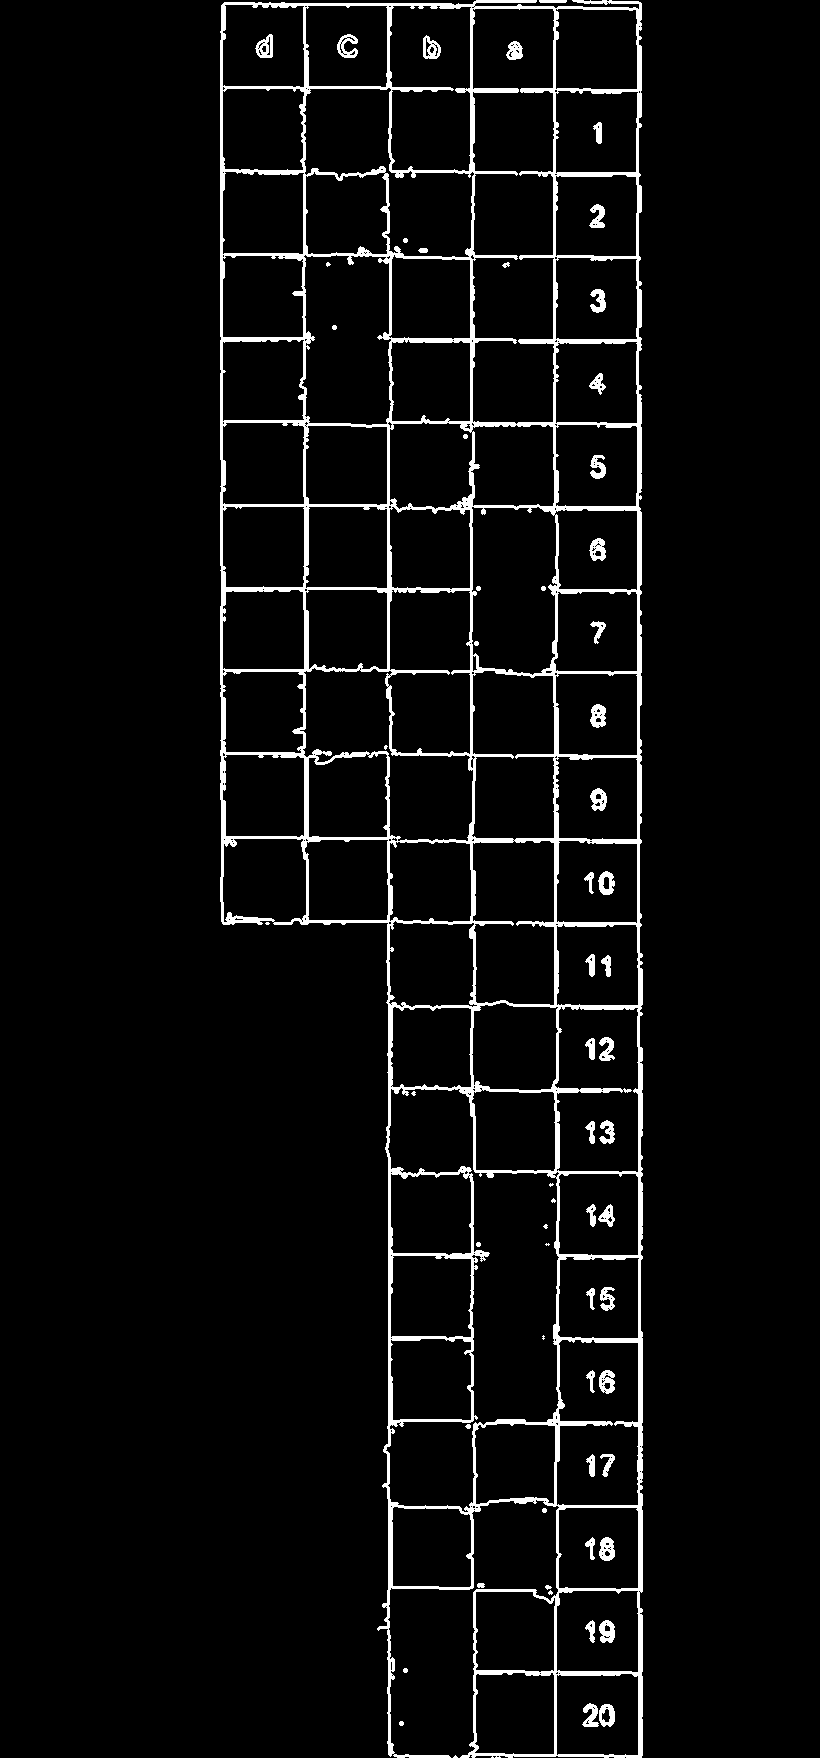

In [11]:
kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
operacao_cross = cv2.morphologyEx(img_canny, cv2.MORPH_DILATE, kernel_cross)
cv2_imshow(operacao_cross)

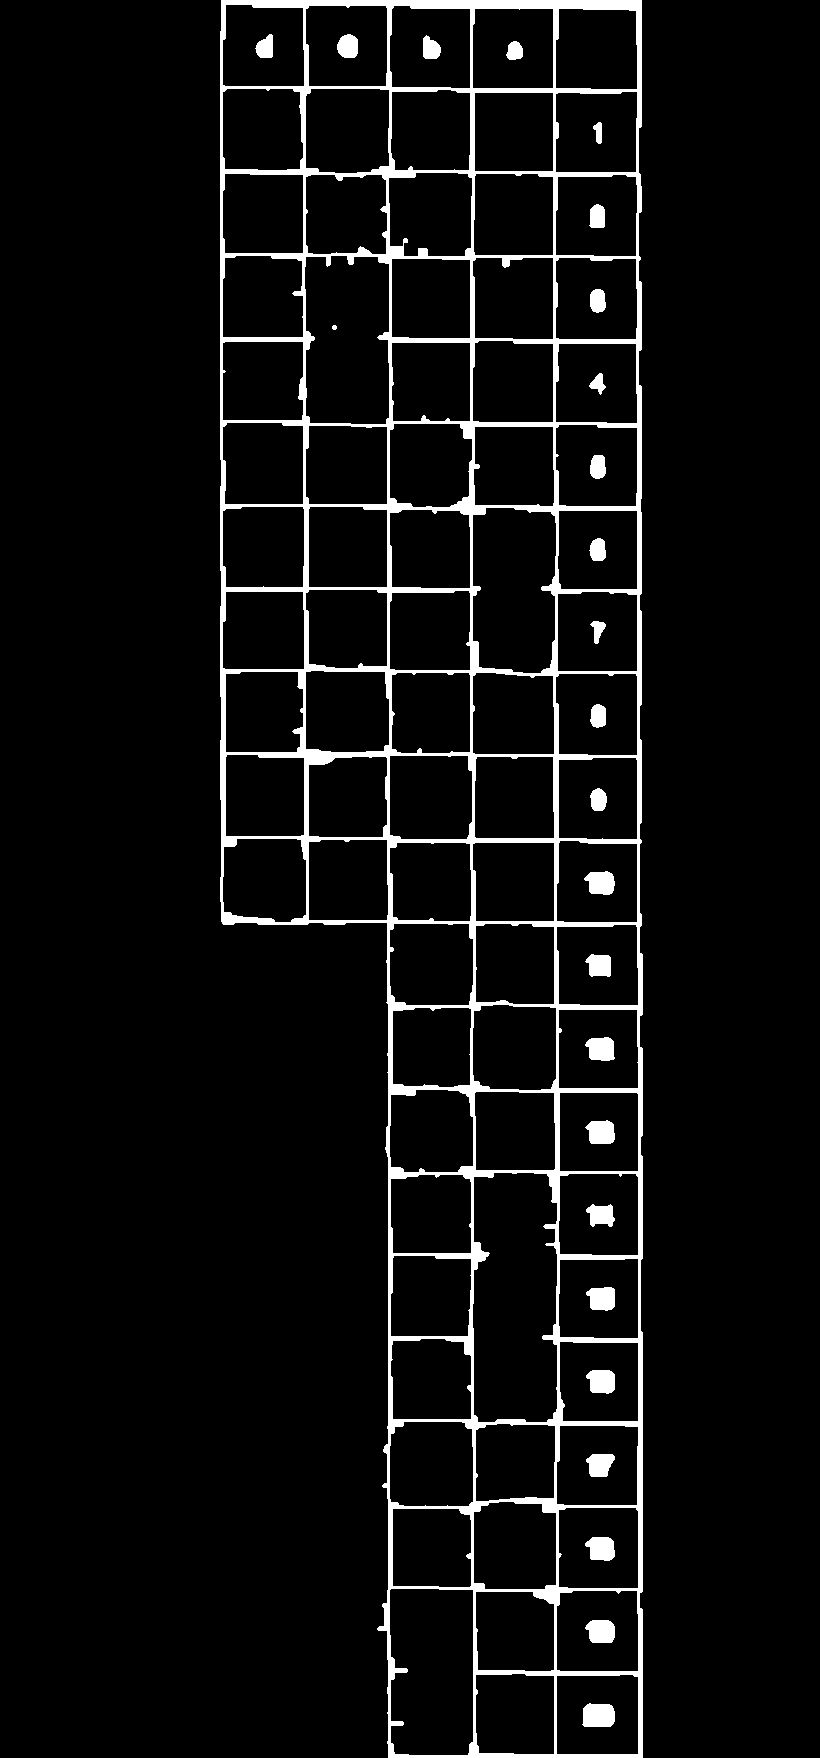

In [12]:
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
operacao_close = cv2.morphologyEx(operacao_cross, cv2.MORPH_CLOSE, kernel_rect,iterations=3)
cv2_imshow(operacao_close)

In [13]:
import numpy as np

l_linhas = cv2.HoughLines(operacao_close, 1, np.pi/180, 80)

l_linhas

array([[[ 638.       ,    0.       ]],

       [[ 389.       ,    0.       ]],

       [[ 472.       ,    0.       ]],

       ...,

       [[ 247.       ,    2.6703537]],

       [[-415.       ,    2.75762  ]],

       [[  85.       ,    2.8099802]]], dtype=float32)

In [0]:
import math

def polar_para_cartesiano(raio, theta):

    seno = math.sin(theta)
    cosseno = math.cos(theta)

    x = raio*cosseno
    y = raio*seno

    return (x,y)

In [0]:
def criar_linha(ponto, theta):

    seno = math.sin(theta)
    cosseno = math.cos(theta)

    x1 = int(ponto[0] + 10000*(-seno))
    x2 = int(ponto[0] - 10000*(-seno))

    y1 = int(ponto[1] + 10000*(cosseno))
    y2 = int(ponto[1] - 10000*(cosseno))

    return (x1,y1,x2,y2)

In [0]:
def desenhar_linha(img, raio, theta):
    ponto = polar_para_cartesiano(raio, theta)
    x1,y1,x2,y2 = criar_linha(ponto, theta)
    imagem_desenhada = cv2.line(img, (x1,y1),(x2,y2), (0,255,0),3)
    return imagem_desenhada

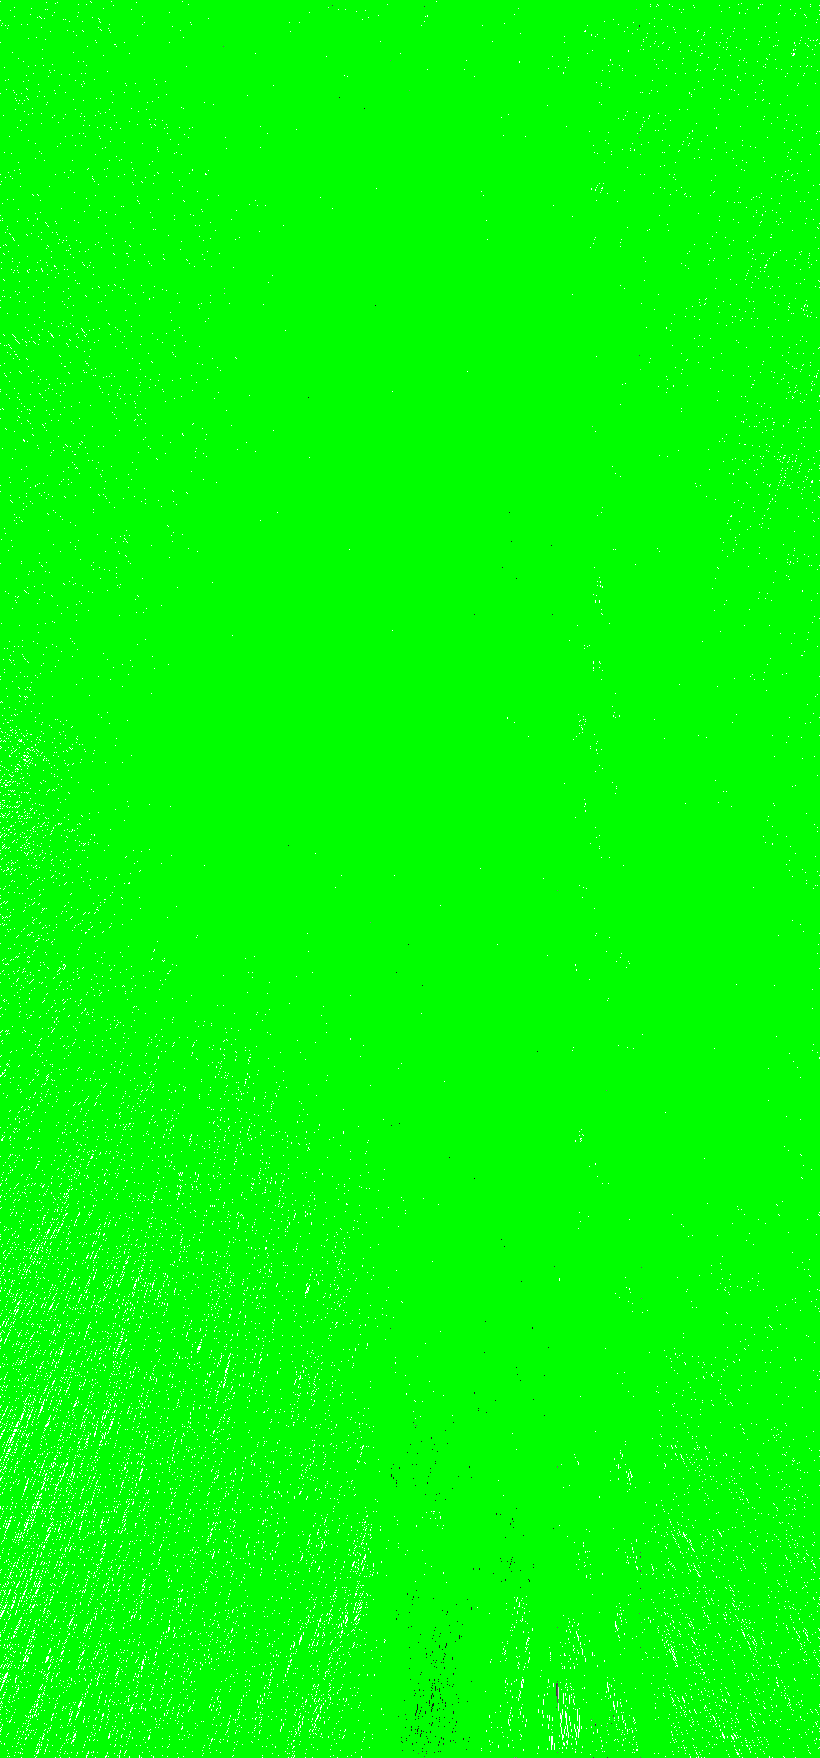

In [17]:
img_copia = imagem.copy()
img_copia = cv2.cvtColor(img_copia, cv2.COLOR_GRAY2BGR)
for linha in l_linhas:
    for raio, theta in linha:
        img_copia = desenhar_linha(img_copia, raio,theta)
cv2_imshow(img_copia)

In [0]:
limites_horizontais = np.array([[imagem.size, imagem.size], # raio, theta LIMITE SUPERIOR
                                [0.0,0.0]], dtype=np.float64) # raio, theta LIMITE INFERIOR

limites_verticais = np.array([[imagem.size, imagem.size], # raio, theta LIMITE ESQUERDO
                                [0.0,0.0]], dtype=np.float64) # raio, theta LIMITE DIREITO


for linha in l_linhas:
    for raio, theta in linha:
        if np.isclose(theta,0.0):#Linhas Verticais
            if raio < limites_verticais[0][0]:
                limites_verticais[0][0] = raio
                limites_verticais[0][1] = theta
            
            if raio > limites_verticais[1][0]:
                limites_verticais[1][0] = raio
                limites_verticais[1][1] = theta

        elif np.isclose(theta, (np.pi/2.0)): #Linhas Horizontais
            if raio<limites_horizontais[0][0]:
                limites_horizontais[0][0] = raio
                limites_horizontais[0][1] = theta
            
            if raio > limites_horizontais[1][0]:
                limites_horizontais[1][0] = raio
                limites_horizontais[1][1] = theta

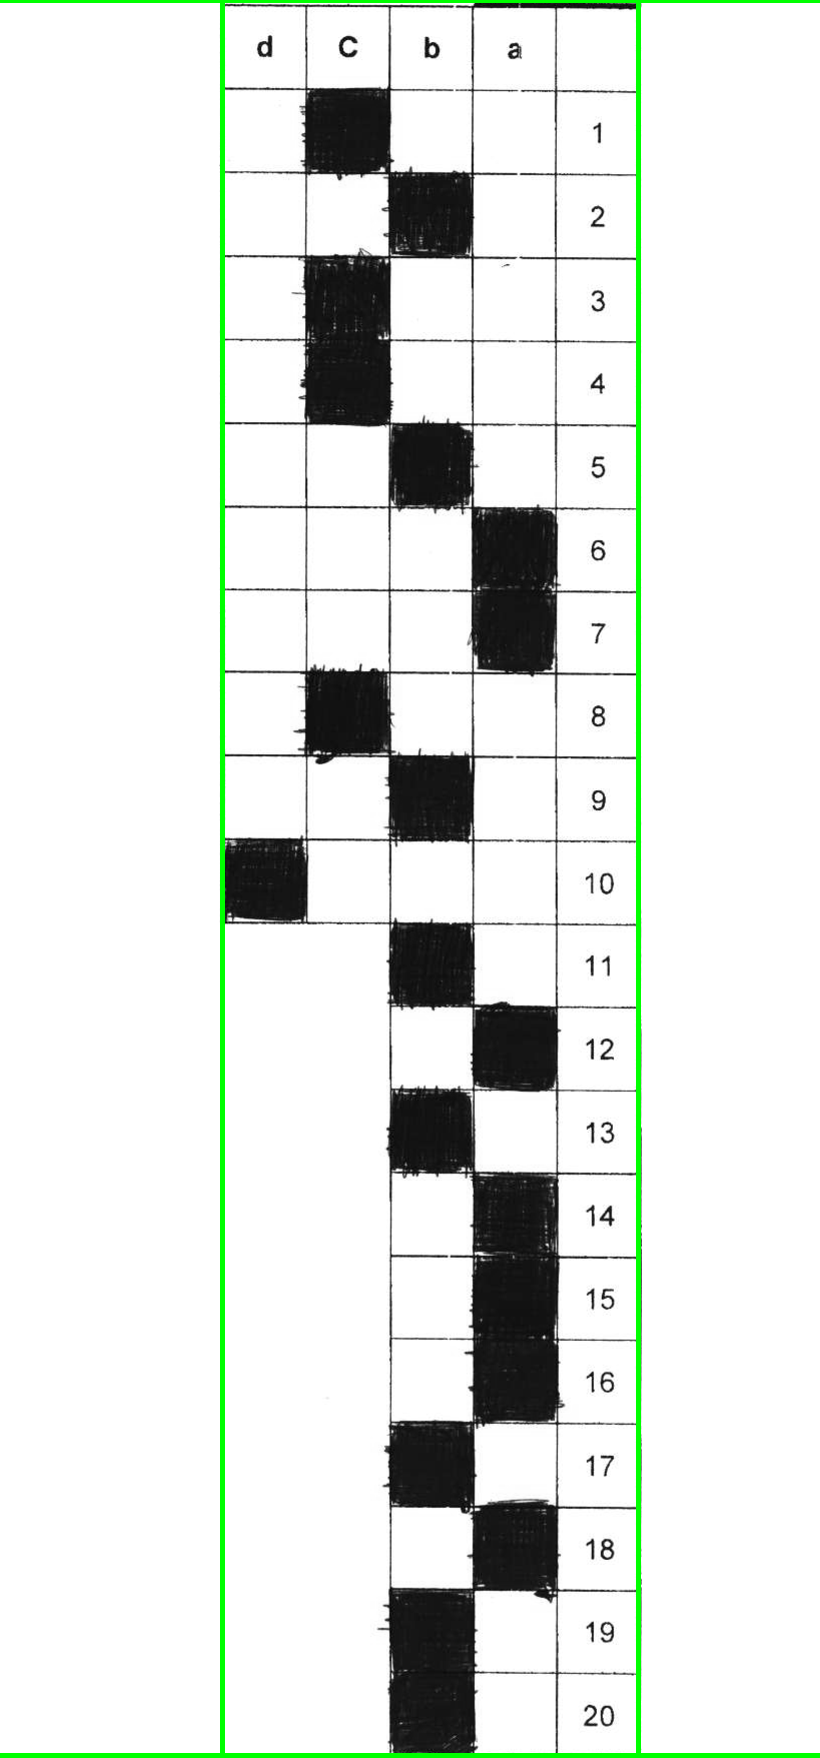

In [21]:
img_copia = imagem.copy()
img_copia = cv2.cvtColor(img_copia, cv2.COLOR_GRAY2BGR)

for valor in range(2):
    img_copia = desenhar_linha(img_copia, limites_horizontais[valor][0], limites_horizontais[valor][1])
    img_copia = desenhar_linha(img_copia, limites_verticais[valor][0], limites_verticais[valor][1])

cv2_imshow(img_copia)

In [0]:
def encontrar_interseccao(raio1, raio2):

    resultante = math.sqrt(raio1**2+raio2**2)
    theta = math.atan((raio1/raio2))

    return (resultante, theta)

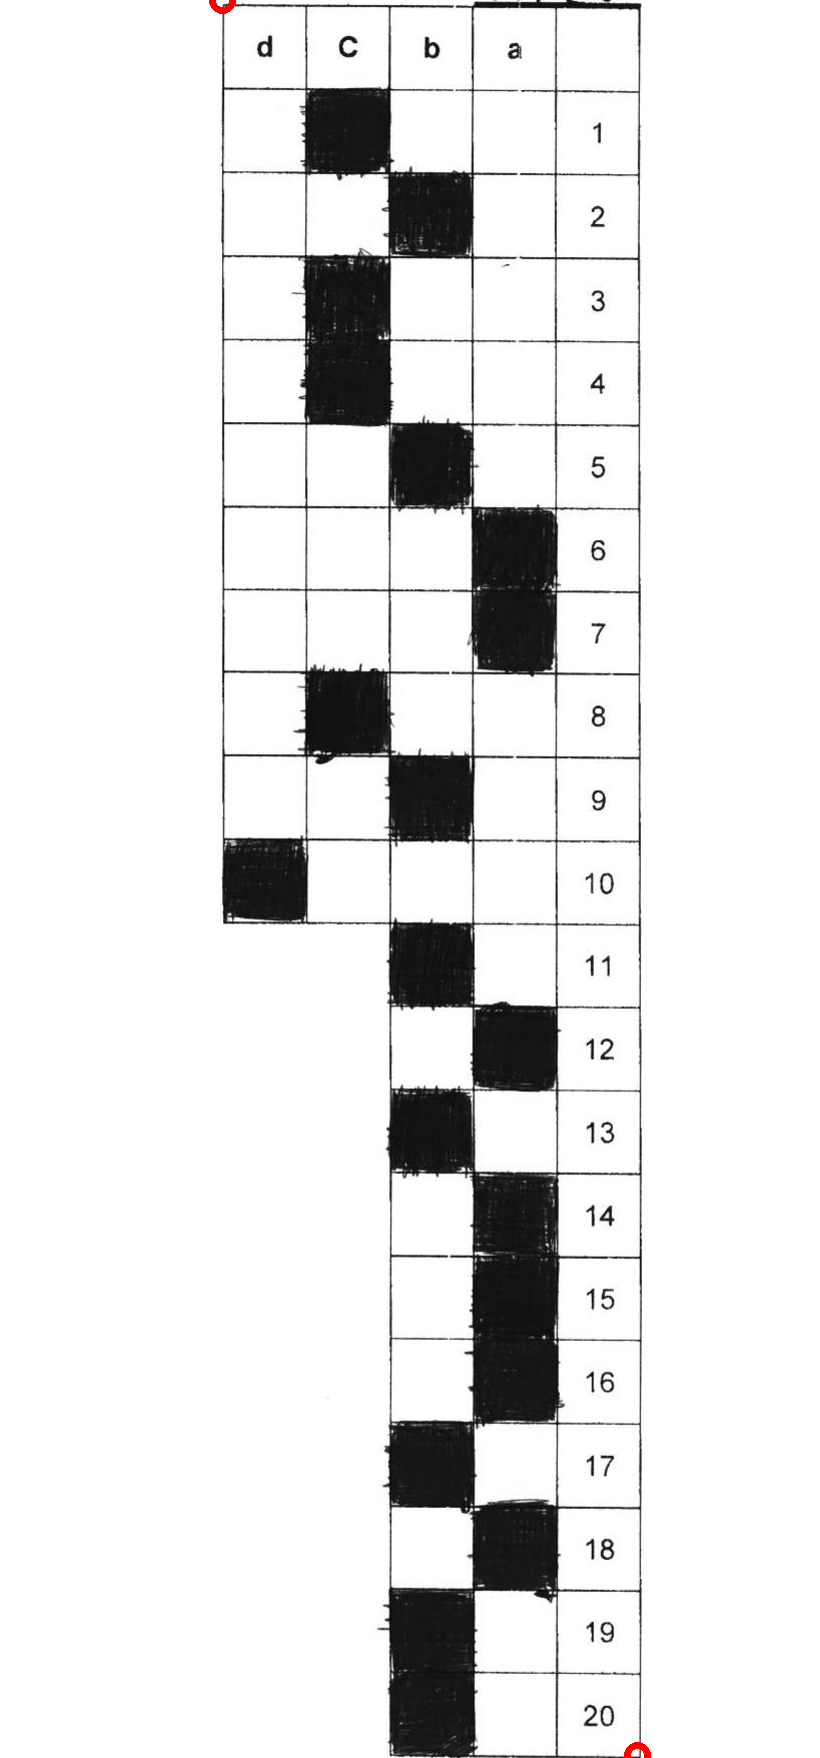

In [27]:
img_copia = imagem.copy()
img_copia = cv2.cvtColor(img_copia, cv2.COLOR_GRAY2BGR)

# superior esquerdo (se)

raio_se, theta_se = encontrar_interseccao(limites_horizontais[0][0], limites_verticais[0][0])
x_se, y_se = polar_para_cartesiano(raio_se, theta_se)
cv2.circle(img_copia, (int(x_se),int(y_se)), 10, (0,0,255), 5)

#inferior direito (id)

raio_id, theta_id = encontrar_interseccao(limites_horizontais[1][0], limites_verticais[1][0])
x_id, y_id = polar_para_cartesiano(raio_id, theta_id)
cv2.circle(img_copia, (int(x_id), int(y_id)),10, (0,0,255), 5)

cv2_imshow(img_copia)

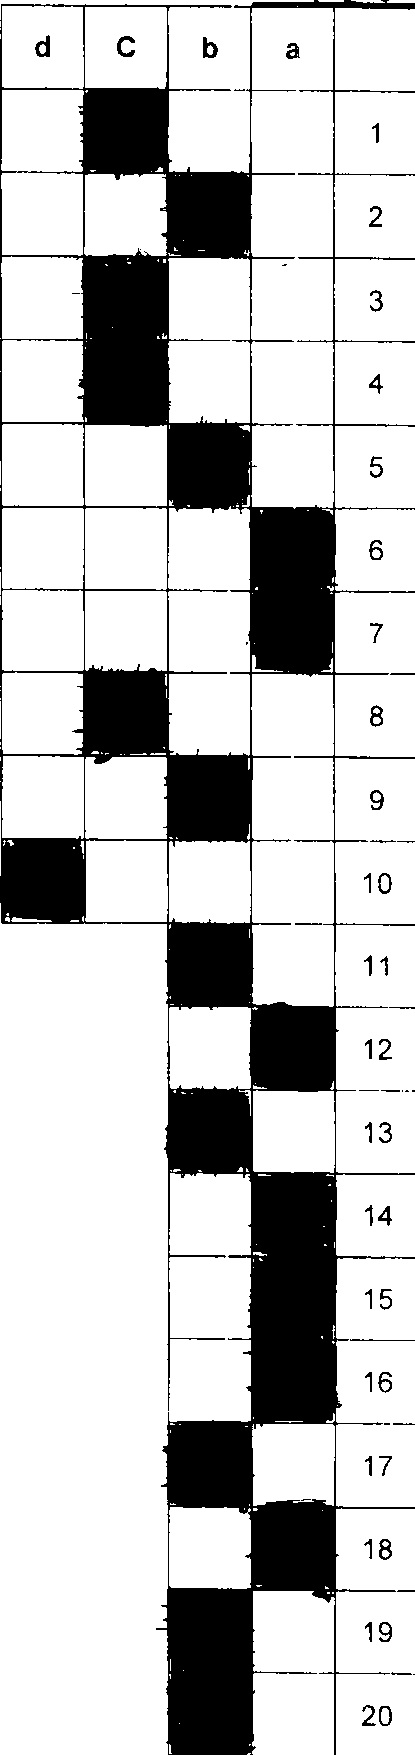

In [28]:
nova_imagem = imagem_binaria[int(y_se):int(y_id),int(x_se):int(x_id)]

cv2_imshow(nova_imagem)

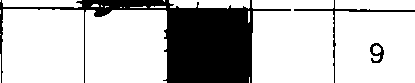

In [33]:
QTD_QUESTOES = 21
QTD_ALTERNATIVAS = 5

espacamento_questao = int(nova_imagem.shape[0]/QTD_QUESTOES)

questao_numero = 9
inicio_questao = int(espacamento_questao*questao_numero)
fim_questao = int(espacamento_questao*(questao_numero+1))

questao = nova_imagem[inicio_questao:fim_questao,:]

cv2_imshow(questao)